<a href="https://colab.research.google.com/github/anahitaoladan/Artificial-Intelligence/blob/main/%D9%BE%D8%A7%DB%8C%D8%A7%D9%86_%D8%AA%D8%B1%D9%85_%D9%87%D9%88%D8%B4_%D9%85%D8%B5%D9%86%D9%88%D8%B9%DB%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-3907103760.py:60: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  a = np.trapz(mf, x)
/tmp/ipython-input-3907103760.py:61: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(x*mf, x) / a if a > 1e-12 else 0.0


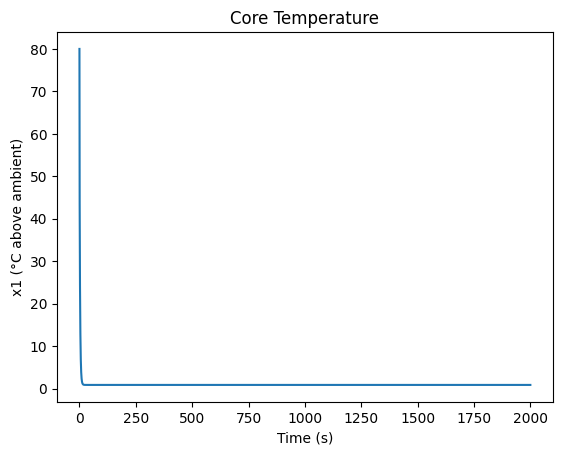

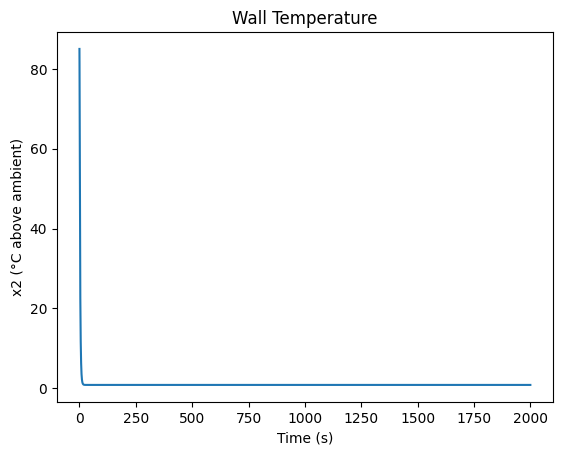

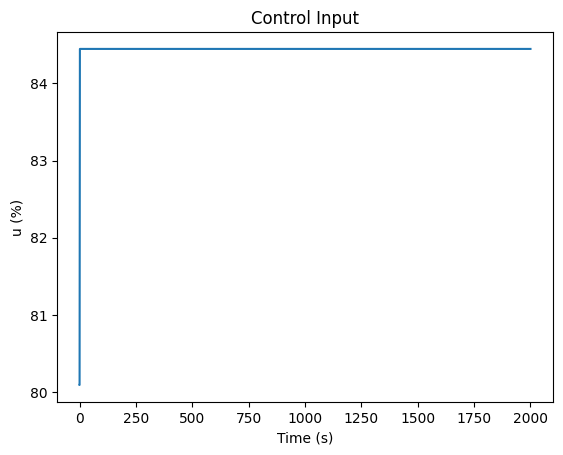

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- membership shapes ---
def trap(x, a, b, c, d):
    x = np.asarray(x, float)
    y = np.zeros_like(x)
    if b > a:
        i = (x > a) & (x < b)
        y[i] = (x[i] - a) / (b - a)
    y[(x >= b) & (x <= c)] = 1.0
    if d > c:
        i = (x > c) & (x < d)
        y[i] = (d - x[i]) / (d - c)
    return y

def tri(x, a, b, c):
    x = np.asarray(x, float)
    y = np.zeros_like(x)
    if b > a:
        i = (x > a) & (x <= b)
        y[i] = (x[i] - a) / (b - a)
    if c > b:
        i = (x > b) & (x < c)
        y[i] = (c - x[i]) / (c - b)
    y[x == b] = 1.0
    return y

# --- universes ---
Ux = np.linspace(0, 500, 2001)   # temperature (°C above ambient)
Uu = np.linspace(0, 100, 1001)   # control (%)

# --- input memberships from the figure (70, 210, 350) ---
X_L = trap(Ux, 0, 0, 70, 210)
X_M = tri (Ux, 70, 210, 350)
X_H = trap(Ux, 210, 350, 500, 500)

# --- output memberships (simple L/M/H on 0..100%) ---
U_L = trap(Uu, 0, 0, 25, 45)
U_M = tri (Uu, 30, 50, 70)
U_H = trap(Uu, 60, 80, 100, 100)

def mu_x(val):
    # degrees for a single scalar x against L/M/H
    L = float(trap(np.array([val]), 0, 0, 70, 210)[0])
    M = float(tri (np.array([val]), 70, 210, 350)[0])
    H = float(trap(np.array([val]), 210, 350, 500, 500)[0])
    return {"L": L, "M": M, "H": H}

# --- rule table (row: x1, column: x2) ---

RULE = {
    ("L","L"): "H", ("L","M"): "M", ("L","H"): "L",
    ("M","L"): "H", ("M","M"): "M", ("M","H"): "L",
    ("H","L"): "M", ("H","M"): "M", ("H","H"): "L"
}
USET = {"L": U_L, "M": U_M, "H": U_H}

def defuzz(x, mf):
    a = np.trapz(mf, x)
    return np.trapz(x*mf, x) / a if a > 1e-12 else 0.0

def controller(x1, x2):
    a, b = mu_x(x1), mu_x(x2)
    agg = np.zeros_like(Uu)
    for i in ("L","M","H"):
        for j in ("L","M","H"):
            w = min(a[i], b[j])
            if w > 0.0:
                agg = np.maximum(agg, np.minimum(w, USET[RULE[(i, j)]]))
    return defuzz(Uu, agg)  # percent

# --- plant (from the given equations) ---
# x1_dot = -2 x1 + x2 + u
# x2_dot =  x1 - x2
def step(x1, x2, u, alpha):
    dx1 = -2.0*x1 + x2 + u
    dx2 =  x1 - x2
    return x1 + alpha*dx1, x2 + alpha*dx2

def run(T=2000.0, alpha=0.05, x10=80.0, x20=85.0, show=True):
    n = int(T/alpha)
    t  = np.linspace(0.0, T, n+1)
    x1 = np.empty(n+1); x2 = np.empty(n+1); uu = np.empty(n+1)
    x1[0], x2[0] = x10, x20
    uu[0] = controller(x1[0], x2[0])

    for k in range(1, n+1):
        u = controller(x1[k-1], x2[k-1]) / 100.0
        uu[k] = u * 100.0
        x1[k], x2[k] = step(x1[k-1], x2[k-1], u, alpha)

    if show:
        plt.figure(); plt.plot(t, x1); plt.xlabel("Time (s)"); plt.ylabel("x1 (°C above ambient)"); plt.title("Core Temperature"); plt.show()
        plt.figure(); plt.plot(t, x2); plt.xlabel("Time (s)"); plt.ylabel("x2 (°C above ambient)"); plt.title("Wall Temperature"); plt.show()
        plt.figure(); plt.plot(t, uu); plt.xlabel("Time (s)"); plt.ylabel("u (%)"); plt.title("Control Input"); plt.show()
    return t, x1, x2, uu

if __name__ == "__main__":
    run()